## Аналитика в Яндекс.Афише

### Описание проекта

На основе данных от Яндекс.Афиши (с июня 2017 по конец мая 2018 года) необходимо сформировать предложения по оптимизации маркетинговых затрат.

В нашем распоряжении:
* лог сервера с данными о посещениях сайта Яндекс.Афиши
* выгрузка всех заказов за этот период
* статистика рекламных расходов

### Цель исследования:
1. Провести исследовательский анализ данных 
2. Построить отчеты и посчитать метрики для следующих параметров: 
    1. __Продукт__
        * *Сколько людей пользуются продуктом в день, неделю, месяц*
        * *Сколько сессий в день*
        * *Сколько длится одна сессия*
        * *Как часто люди возвращаются*
    2. __Продажи__
        * *Когда люди начинают покупать продукт*
        * *Сколько раз покупают за период*
        * *Какой средний чек*
        * *Сколько денег приносят? (LTV)*
    3. __Маркетинг__
        * *Сколько денег потратили: __Всего__ / __на каждый источник__ / __по времени__*
        * *Сколько стоило привлечение одного покупателя из каждого источника?*
        * *На сколько окупились расходы? (ROI)*
3. Сформулировать вывод на основании проведенного анализа и дать рекомендации для отдела маркетологов

### Информация о входных данных


Таблица __visits__ - лог сервера с информацией о посещениях сайта:
* __``Uid``__ — *уникальный идентификатор пользователя*
* __``Device``__ — *категория устройства пользователя*
* __``Start Ts``__ — *дата и время начала сессии*
* __``End Ts``__ — *дата и время окончания сессии*
* __``Source Id``__ — *идентификатор рекламного источника, из которого пришел пользователь*


Таблица __orders__ - информация о заказах:
* __``Uid``__ — *уникальный id пользователя, который сделал заказ*
* __``Buy Ts``__ — *дата и время заказа*
* __``Revenue``__ — *выручка Яндекс.Афиши с этого заказа*


Таблица __costs__ - информация о затратах на маркетинг:
* __``source_id``__ — *идентификатор рекламного источника*
* __``dt``__ — *дата*
* __``costs``__ — *затраты на этот рекламный источник в этот день*

### Загрузим данные и подготовим их к анализу

#### Загрузка библиотек

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
from IPython.display import display
from scipy import stats as st
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

#### Загрузка данных

In [2]:
visits = pd.read_csv('visits_log.csv')  
orders = pd.read_csv('orders_log.csv')  
marketing = pd.read_csv('costs.csv')

In [3]:
# Создаю функцию для получения основной информации о датафрейме
def datainfo(dataframe):
    display(dataframe.head(10))
    display(dataframe.describe())
    dataframe.info()
    print("", sep = '\n\n')
    print("Name of columns:")
    display(dataframe.columns)
    print("", sep = '\n\n')
    print("Unique values:")
    display(dataframe.nunique())
    print("", sep = '\n\n')
    print("Sum of NaN values:")
    display(dataframe.isna().sum())

### EDA

In [4]:
datainfo(visits)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB

Name of columns:


Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')


Unique values:


Device            2
End Ts       224760
Source Id         9
Start Ts     224303
Uid          228169
dtype: int64


Sum of NaN values:


Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

In [5]:
datainfo(orders)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB

Name of columns:


Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')


Unique values:


Buy Ts     45991
Revenue     1149
Uid        36523
dtype: int64


Sum of NaN values:


Buy Ts     0
Revenue    0
Uid        0
dtype: int64

In [6]:
datainfo(marketing)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB

Name of columns:


Index(['source_id', 'dt', 'costs'], dtype='object')


Unique values:


source_id       7
dt            364
costs        2396
dtype: int64


Sum of NaN values:


source_id    0
dt           0
costs        0
dtype: int64

Во всех таблицах проблема некорректного типа данных дат (object вместо datetime64)

In [7]:
# Функцию для изменения типа данных на 'datetime64'
def convert_to_time(dataframe, column, formtype):
    if formtype == 1:    # Если формат даты (год-месяц-день час:минута:секунда)
        result = pd.to_datetime(dataframe[column], format='%Y-%m-%d %H:%M:%S')
        return result
    elif formtype == 2:  # Если формат даты (год-месяц-день)
        result = pd.to_datetime(dataframe[column], format='%Y-%m-%d')
        return result
    else:
        print('Некорректный формат даты')

In [8]:
#Изменяем типы данных и проверяем
visits['End Ts'] = convert_to_time(visits, 'End Ts', 1) 
visits['Start Ts'] = convert_to_time(visits, 'Start Ts', 1)
orders['Buy Ts'] = convert_to_time(orders, 'Buy Ts', 1)
marketing['dt'] = convert_to_time(marketing, 'dt', 2)
print(visits['End Ts'].dtype)  
print(visits['Start Ts'].dtype) 
print(orders['Buy Ts'].dtype)
print(marketing['dt'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


In [9]:
#напишем функцию перевода столбцов к нижнему регистру и замены пробелов на "_" 
def replace_columns_names(data):
    list_of_columns = []
    for column in data.columns:
        column = column.lower()
        column = column.replace(' ', '_')
        list_of_columns.append(column)
    data.columns = list_of_columns
    return data

In [10]:
visits = replace_columns_names(visits)
orders = replace_columns_names(orders)
marketing = replace_columns_names(marketing)

В таблице orders есть значения с revenue = 0, исследуем этот вопрос

In [11]:
print('Количество строк с нулевым значением:', orders[orders['revenue'] == 0]['revenue'].count())
print('Доля нулевых значений от общего количества записей: {:.2%}'.format(orders[orders['revenue'] == 0]['revenue'].count() / len(orders)))

Количество строк с нулевым значением: 51
Доля нулевых значений от общего количества записей: 0.10%


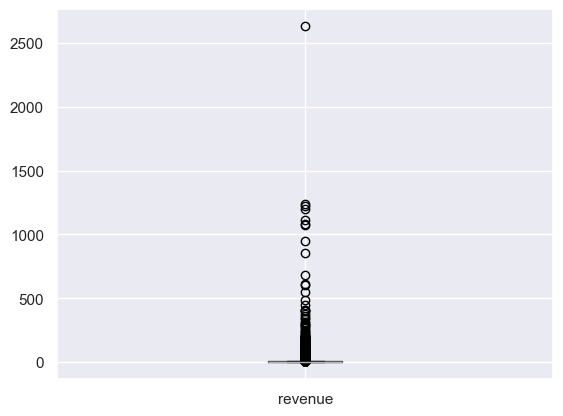

In [12]:
orders.boxplot(column='revenue')
plt.show()

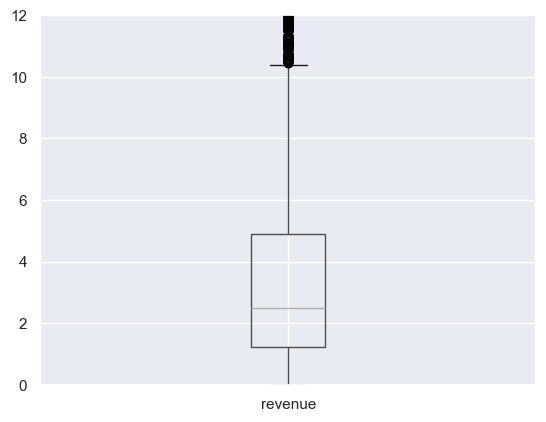

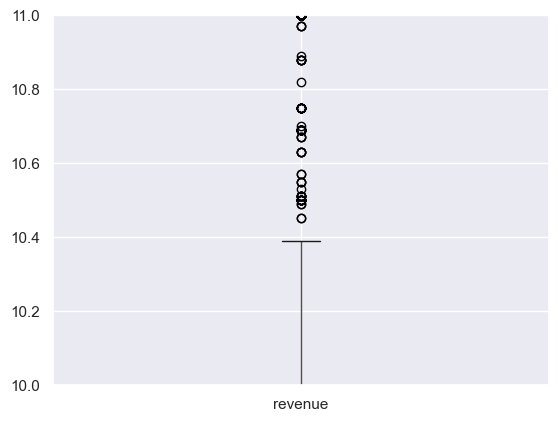

In [13]:
plt.ylim(0, 12)
orders.boxplot(column='revenue', figsize=(10,5))
plt.figure()
plt.ylim(10, 11)
orders.boxplot(column='revenue', figsize=(10,5)) # revenue < 10.5
plt.show()

In [14]:
#видим что выбросы начинаются со значения 10.4
print(len(orders[orders['revenue'] >= 10.4]))
print('Доля выбросов:', round((len(orders[orders['revenue'] >= 10.4]) / len(orders) * 100)), '%')

3990
Доля выбросов: 8 %


### Расчет метрик и построение отчётов

#### Продукт

***Количество пользователе продуктом в день(DAU), неделю(WAU), месяц(MAU)***

* __DAU__ *(от англ. daily active users)* — количество уникальных пользователей в день
* __WAU__ *(от англ. weekly active users)* — количество уникальных пользователей в неделю
* __MAU__ *(от англ. monthly active users)* — количество уникальных пользователей в месяц

In [15]:
#разобъем дату на столбцы: год, месяц, неделя, день
visits['day'] = visits['start_ts'].dt.day
visits['week'] = visits['start_ts'].dt.isocalendar().week
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year
visits['date'] = visits['start_ts'].dt.date

visits.sample(5)

,device,end_ts,source_id,start_ts,uid,day,week,month,year,date
278584,touch,2018-04-25 12:59:00,4,2018-04-25 12:32:00,15458247899234087508,25,17,4,2018,2018-04-25
231375,desktop,2018-01-12 09:56:00,4,2018-01-12 09:39:00,6499665114801106571,12,2,1,2018,2018-01-12
352524,desktop,2018-05-30 12:13:00,3,2018-05-30 12:13:00,7989820037556685292,30,22,5,2018,2018-05-30
116488,desktop,2018-05-30 22:01:00,5,2018-05-30 21:58:00,4302699150505555412,30,22,5,2018,2018-05-30
115654,touch,2017-10-15 23:14:00,3,2017-10-15 23:12:00,3014632870619292961,15,41,10,2017,2017-10-15


In [16]:
"""
Функция подсчитывает количество уникальных пользователей и количество сессий за период, выводит графики;
строит графики распределений, а также выводит описание .describe() группировки.
Входные параметры:
    `df` - датафрейм с информацией о посещениях сервиса
    `period` - список полей для группировки по периоду
    `period_name` - название периода в винительном падеже для заголовков.
"""
def nusers_period(df, period, period_name):  
    nusers = (df.groupby(period)
                  .agg(
                      user_count = ('uid','nunique'),
                      session_count = ('uid','count'))
             )
    nusers['sessions_per_user'] = nusers['session_count'] /  nusers['user_count']
    display(nusers.sample(5))
    nusers.sort_values(by=period, inplace=True)
    nusers[['user_count', 'session_count']].plot(figsize=(15,5), grid=True, style='o', title='Количество пользователей/сессий в '+ period_name)
    plt.ylabel('количество пользователей/сессий')
    plt.show()
    
    plt.figure(figsize=(10,5))
    sns.histplot(nusers['user_count'], bins=20, label='пользователи',kde=True, stat="density")
    sns.histplot(nusers['session_count'], bins=20, label='сессии',kde=True, stat="density")
    plt.title('Распределение количества пользователей/сессий в ' + period_name)
    plt.legend()
    plt.show() 
    
    display(nusers.describe())

,user_count,session_count,sessions_per_user
date,,,
2017-07-30,311,332,1.067524
2017-07-24,554,592,1.068592
2018-03-05,1209,1328,1.098428
2017-08-22,502,541,1.077689
2018-03-11,821,884,1.076736


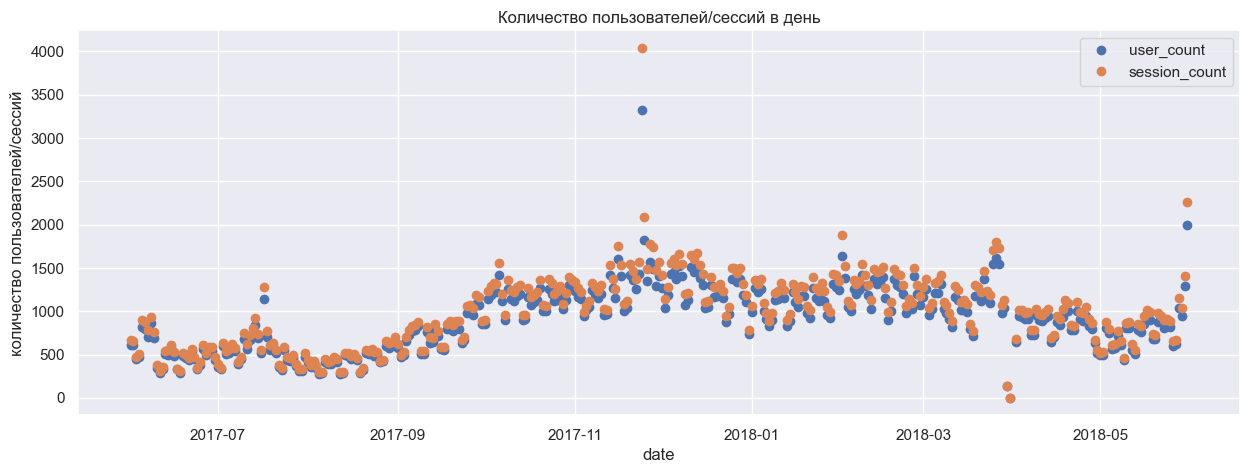

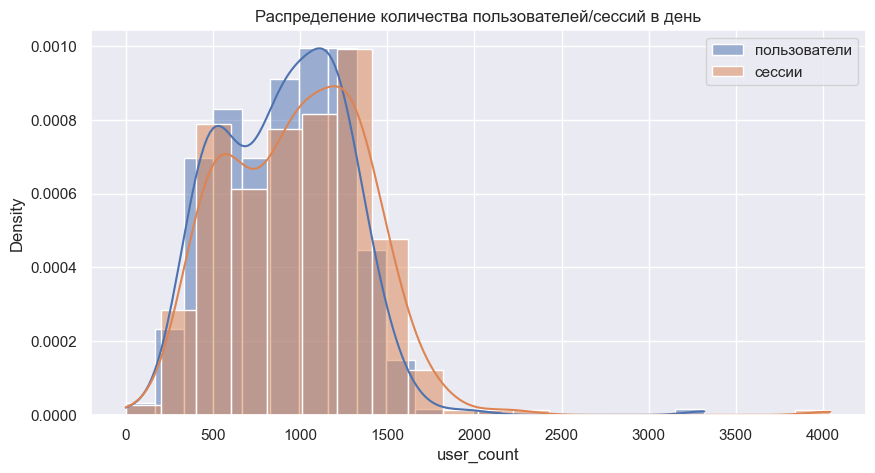

,user_count,session_count,sessions_per_user
count,364.000000,364.000000,364.000000
mean,907.991758,987.362637,1.082170
std,370.513838,418.994796,0.020876
min,1.000000,1.000000,1.000000
25%,594.000000,635.500000,1.070321
50%,921.000000,1003.000000,1.082488
75%,1173.000000,1280.000000,1.093876
max,3319.000000,4042.000000,1.217837


In [17]:
# Посмотрим, сколько людей пользуются сервисом в день:
nusers_period(visits, ['date'], 'день')

#### Интерпретация результатов:
* В среднем сервисов в день пользуется 907 человек, в то время как сессий в среднем 987. Каждый человек в среднем пользуется сервисом не более одного раза в день.
* В конце декабря наблюдается увеличение количества пользователей/сессий 

user_count  session_count  sessions_per_user
year week                                              
2018 7           7759           9272           1.194999
     12          7898           9393           1.189288
     13          4940           5862           1.186640
     3           6972           8317           1.192915
     4           7060           8488           1.202266

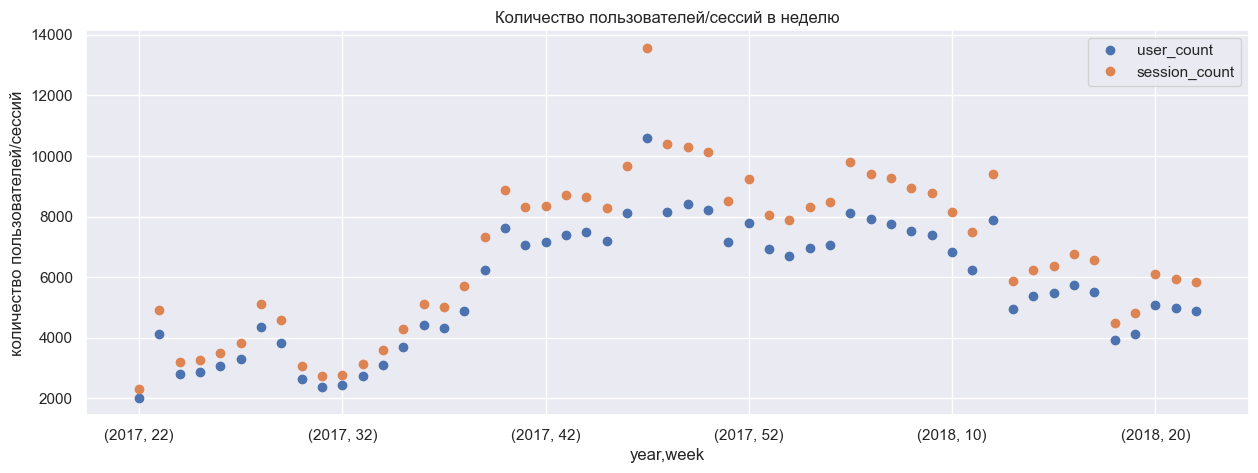

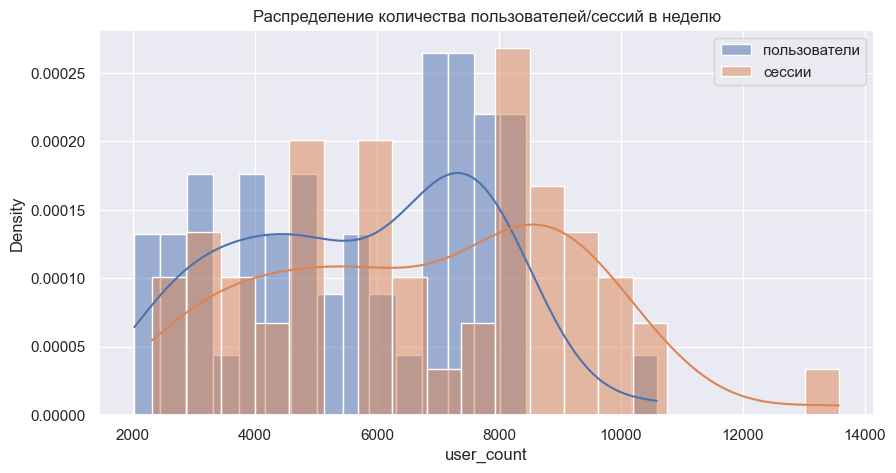

,user_count,session_count,sessions_per_user
count,53.000000,53.000000,53.000000
mean,5716.245283,6781.132075,1.179025
std,2049.898027,2549.571427,0.029427
min,2021.000000,2309.000000,1.137248
25%,4128.000000,4803.000000,1.159576
50%,5740.000000,6768.000000,1.175714
75%,7401.000000,8712.000000,1.190836
max,10586.000000,13572.000000,1.282071


In [18]:
# Посмотрим, сколько людей пользуются сервисом в неделю:
nusers_period(visits, ['year', 'week'], 'неделю')

* Среднее количество пользователей - 5716, сессий - 6781
* Тенденции в принципе сохраняются, также видим всплеск количества сессий в декабре
* Также сохраняется соотношение, что в среднем пользователь заходит на платформу не чаще одного раза в неделю.

user_count  session_count  sessions_per_user
year month                                              
2018 2           28749          37182           1.293332
2017 7           14183          17828           1.256998
     9           18975          23907           1.259921
     12          31557          41983           1.330386
     8           11631          14355           1.234202

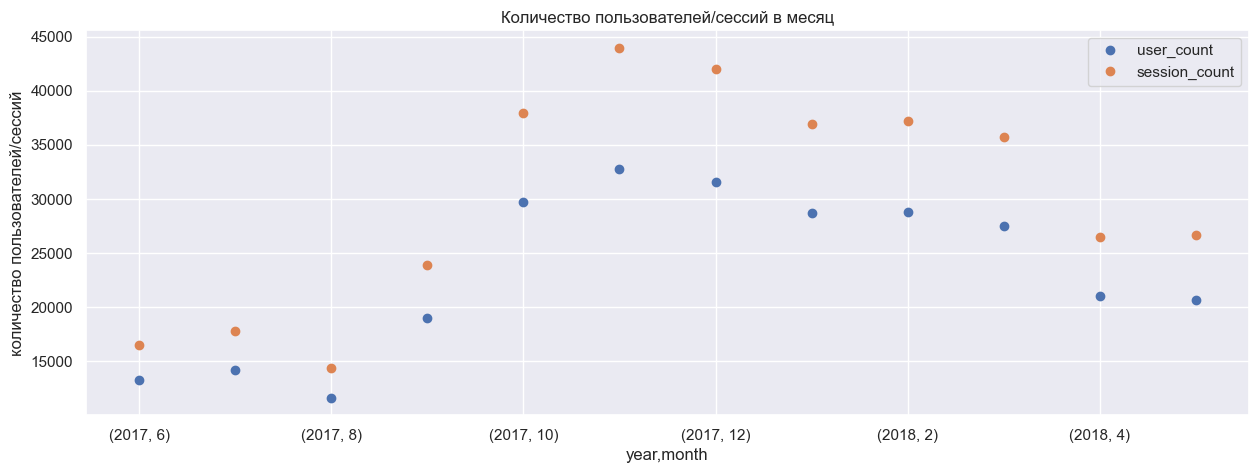

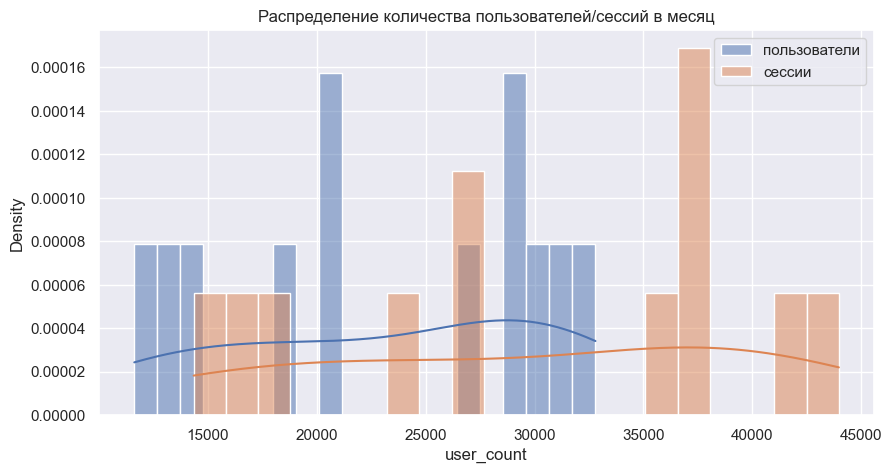

,user_count,session_count,sessions_per_user
count,12.000000,12.000000,12.000000
mean,23228.416667,29950.000000,1.280889
std,7546.380462,10307.835846,0.032217
min,11631.000000,14355.000000,1.234202
25%,17777.000000,22387.250000,1.259190
50%,24240.500000,31157.000000,1.281448
75%,28984.750000,37362.250000,1.294672
max,32797.000000,43969.000000,1.340641


In [19]:
# Посмотрим, сколько людей пользуются сервисом в месяц:
nusers_period(visits, ['year', 'month'], 'месяц')

* При рассмотрении месяцев уже видно, что суммарно количества сессий и пользователей больше в ноябре
* Среднее количество сессий на пользователя - 1.28 в месяц
* Среднее количество пользователей в месяц - 23228, количество сессий - 29950

***Средняя продолжительность сессии***

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64


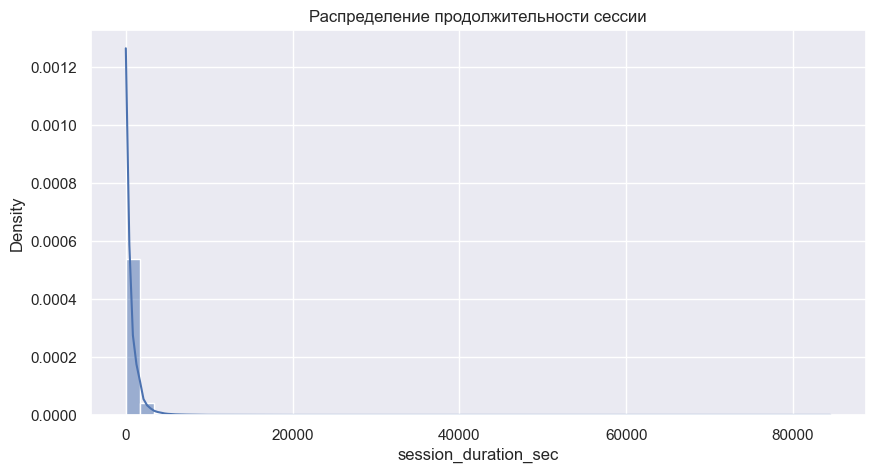

In [20]:
# Рассчитаем среднюю продолжительность сессии (ASL - average session length):
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

print(visits['session_duration_sec'].describe())

# Посмотрим на распределение продолжительности сессии:
plt.figure(figsize=(10,5))
sns.histplot(visits['session_duration_sec'], bins=50, kde=True, stat="density")
plt.title('Распределение продолжительности сессии')
plt.show() 

В данном слечае на графике мало что можно увидеть, но явно понятно, что среднее будет плохо описывать метрику "Средняя продолжительность сессии", поэтому воспользуемся модой

In [21]:
print('Средняя продолжительность сессии:', visits['session_duration_sec'].mode()[0], 'секунд')

Средняя продолжительность сессии: 60 секунд


In [22]:
# Посмотрим есть ли связь с платформой пользователя:

print('touch - мода:',visits[visits['device']=='touch']['session_duration_sec'].mode()[0])
print('desktop - мода:',visits[visits['device']=='desktop']['session_duration_sec'].mode()[0])
print('touch - медиана:',visits[visits['device']=='touch']['session_duration_sec'].median())
print('desktop - медиана:',visits[visits['device']=='desktop']['session_duration_sec'].median())
print('touch - среднее:',visits[visits['device']=='touch']['session_duration_sec'].mean())
print('desktop - среднее:',visits[visits['device']=='desktop']['session_duration_sec'].mean())

touch - мода: 60
desktop - мода: 60
touch - медиана: 180.0
desktop - медиана: 360.0
touch - среднее: 479.6194066072517
desktop - среднее: 703.9469773429258


* По моде разницы в платформах нет
* Если смотреть на медиану и среднее арифметическое, то явно видно, что по продолжительности сессии хвосты(выбросы) дольше на компьютере случаются

***Частота возвращений пользователя (sticky factor)***

***SF (Sticky Factor)*** — показатель, который отражает регулярноcть взаимодействия с продуктом в течении выбранного периода времени.

In [23]:
# Рассчитаем среднюю частоту возвращения пользователей (sticky factor):

mau_total = visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()
dau_total = visits.groupby('date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean()

sticky_wau = dau_total / wau_total
sticky_mau = dau_total / mau_total

print('Week sticky factor: {:.2%}'.format(sticky_wau.iloc[0]))
print('Month sticky factor: {:.2%}'.format(sticky_mau.iloc[0]))

Week sticky factor: 15.88%
Month sticky factor: 3.91%


#### Коэффициент удержания пользователей (Retention Rate)

In [24]:
# Добавим в таблицу с сессиями информацию о первом визите пользователя:
first_visit_date = visits.groupby(['uid'])['date'].min()
first_visit_date.name = 'first_visit_date'
user_visits = visits.join(first_visit_date, on='uid')
display(user_visits.sample(5))

,device,end_ts,source_id,start_ts,uid,day,week,month,year,date,session_duration_sec,first_visit_date
89192,touch,2017-06-12 04:21:00,5,2017-06-12 04:19:00,15210611929859283567,12,24,6,2017,2017-06-12,120,2017-06-12
152753,desktop,2017-12-26 17:26:00,4,2017-12-26 17:12:00,16977487840759243913,26,52,12,2017,2017-12-26,840,2017-12-26
286491,touch,2018-04-24 21:37:00,1,2018-04-24 20:47:00,11875509877840524848,24,17,4,2018,2018-04-24,3000,2018-04-24
348269,desktop,2017-06-06 20:22:00,5,2017-06-06 20:10:00,12974973012454807207,6,23,6,2017,2017-06-06,720,2017-06-06
321242,touch,2018-01-20 17:52:00,4,2018-01-20 17:51:00,12551495625814204286,20,3,1,2018,2018-01-20,60,2018-01-20


In [25]:
# Добавим месяц сессии и месяц первого визита:
user_visits['visit_month'] = user_visits['date'].values.astype('datetime64[M]')
user_visits['first_visit_month'] = user_visits['first_visit_date'].values.astype('datetime64[M]')

# Добавим lifetime пользователя в рамках когорты:
user_visits['cohort_lifetime'] = user_visits['visit_month'] - user_visits['first_visit_month']
user_visits['cohort_lifetime'] = user_visits['cohort_lifetime'] / np.timedelta64(30,'D')
user_visits['cohort_lifetime'] = round(user_visits['cohort_lifetime']).astype('int')

# Посчитаем для каждой когорты количество активных пользователей на каждый месяц:
cohorts = user_visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

# Найдём исходное количество пользователей в когорте:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

# Объединим данные по когортам с исходным количеством пользователей в когорте:
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')

# Рассчитаем Retention Rate:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

display(cohorts.head(5))

,first_visit_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


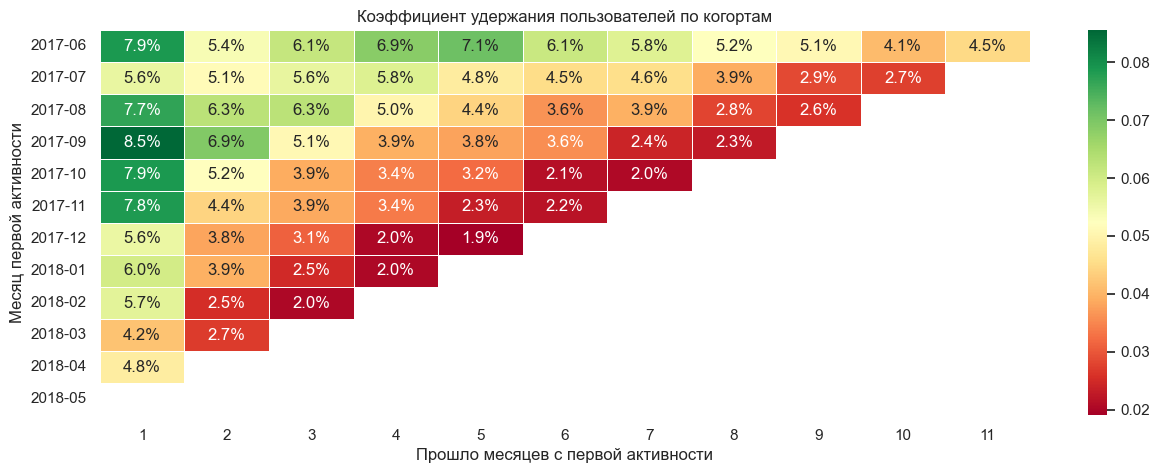

In [26]:
retention_pivot = cohorts.pivot_table(index='first_visit_month', columns='cohort_lifetime', values='retention', aggfunc='sum')
retention_pivot = retention_pivot.reset_index()
retention_pivot['first_visit_month'] = retention_pivot['first_visit_month'].dt.strftime('%Y-%m')
retention_pivot = retention_pivot.set_index('first_visit_month')

sns.set(style='white')
plt.figure(figsize=(15, 5))
plt.title('Коэффициент удержания пользователей по когортам')

sns.heatmap(retention_pivot.loc[:,1:11], annot=True, fmt='.1%', linewidths=.5, cmap = 'RdYlGn');
plt.ylabel('Месяц первой активности')
plt.xlabel('Прошло месяцев с первой активности')
plt.show()

Коэффициенты удержания (Retention Rate) очень низкие, пользователи возвращаются очень редко

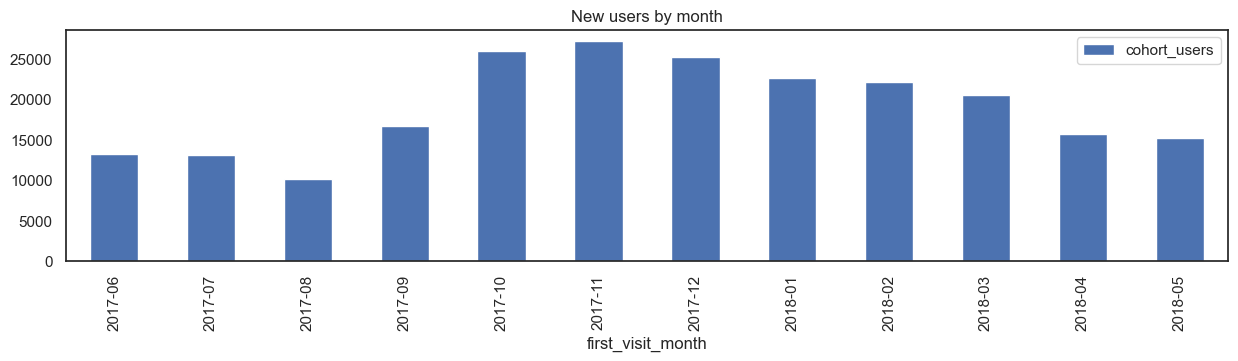

In [27]:
#посмотрим количества новых пользователей по месяцам
cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')
cohorts = cohorts.set_index('first_visit_month')
new_users_by_month = cohorts[cohorts['cohort_lifetime'] == 0][['cohort_users']]
new_users_by_month.plot(kind = 'bar', figsize = (15,3), title = 'New users by month')
plt.show()

#### Продажи

***Когда люди начинают покупать продукт***

***Сколько раз покупают за период***

***Средний чек***

***Сколько денег приносят?(LTV)***

In [28]:
# Добавим в таблицу с заказами `orders` информацию о первом заказе пользователя.
# Составим справочник с датой первого заказа:
first_order_date = orders.groupby('uid')['buy_ts'].min() 
first_order_date.name = 'first_order_date'

# Объединим таблицы:
orders = orders.join(first_order_date, on='uid')
display(orders.head())

,buy_ts,revenue,uid,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


Доля пользователей, совершивших хотя бы одну покупку: 16.01%


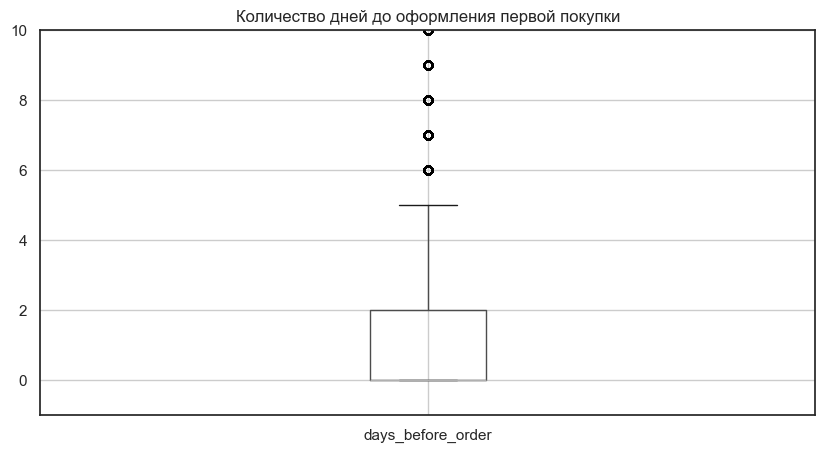

count    36523.000000
mean        16.729869
std         46.959088
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: days_before_order, dtype: float64


In [57]:
# Построим таблицу с первой сессией каждого пользователя:
first_visits = visits.groupby('uid').agg(first_ts=('start_ts', 'min'))
first_visits = pd.DataFrame(first_visits)

# Добавим в таблицу `first_visits` информацию о первой покупке для каждого пользователя:
first_visits = first_visits.join(first_order_date, on='uid').reset_index()

# Рассчитаем количество дней от первой сессии до первой покупки:
first_visits['days_before_order'] = (first_visits['first_order_date'] - first_visits['first_ts']).dt.days
first_visits['time_to_first_purchase'] = (first_visits['first_order_date'] - first_visits['first_ts'])/np.timedelta64(1, 'm')
#display(first_visits.sample(5))
print('Доля пользователей, совершивших хотя бы одну покупку: {:.2%}'.format(first_visits[~first_visits['days_before_order'].isna()]['uid'].count() / first_visits.shape[0]))

plt.figure(figsize=(10,5))
plt.title('Количество дней до оформления первой покупки')
plt.ylim(-1, 10)
first_visits.boxplot(column='days_before_order')
plt.show()

print(first_visits['days_before_order'].describe())

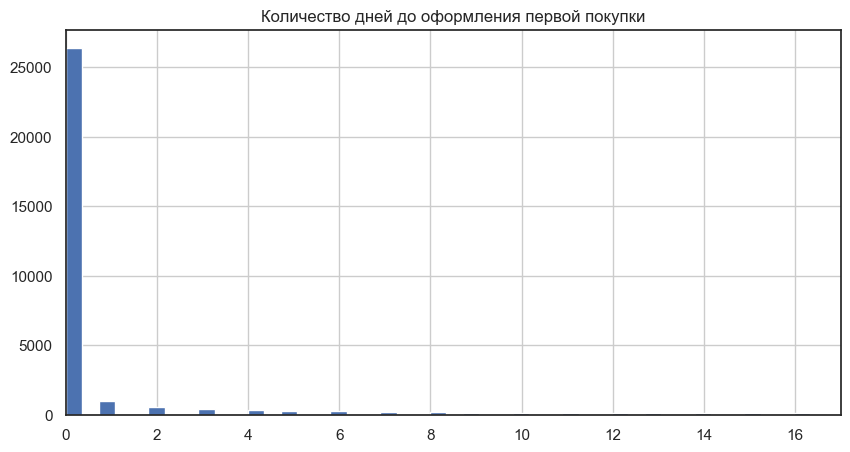

In [53]:
plt.figure(figsize=(10,5))
plt.title('Количество дней до оформления первой покупки')
first_visits['days_before_order'].hist(bins=1000)
plt.xlim(0, 17)
plt.show()

Большинство пользователей совершают покупку в день своей первой сессии.

#### Сколько покупок совершается за период?

In [58]:
# Добавим в таблицу `orders` необходимые для дальнейшего анализа поля -
# месяц заказа `order_month` и месяц первого заказа `first_order_month`:
orders['first_order_month'] = orders['first_order_date'].values.astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].values.astype('datetime64[M]')
display(orders.sample(5))

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
7660,2017-09-13 15:08:00,3.67,2148167223562433737,2017-09-13 15:08:00,2017-09-01,2017-09-01
3119,2017-07-12 11:46:00,7.33,7609136203030565274,2017-07-12 11:46:00,2017-07-01,2017-07-01
40571,2018-03-19 13:13:00,1.40,15719800891640186183,2018-03-19 13:13:00,2018-03-01,2018-03-01
5145,2017-08-10 14:23:00,3.67,2385431701654589490,2017-08-10 14:23:00,2017-08-01,2017-08-01
30844,2018-01-24 16:58:00,0.79,2324790312959910225,2018-01-03 15:39:00,2018-01-01,2018-01-01


Проведём когортный анализ и посмотрим, как по месяцам изменяется количество пользователей, совершивших покупку впервые.

,orders_count,users_nunique,revenue,orders_per_user
first_order_month,,,,
2017-06-01,4322,2023,24031.69,2.136431
2017-07-01,2797,1923,16127.92,1.454498
2017-08-01,2133,1370,11606.26,1.556934
2017-09-01,3730,2581,34676.32,1.445176
2017-10-01,5573,4340,27603.45,1.284101
2017-11-01,5361,4081,26098.99,1.313649
2017-12-01,5483,4383,33485.74,1.250970
2018-01-01,4069,3373,16663.13,1.206345
2018-02-01,4143,3651,16750.50,1.134758


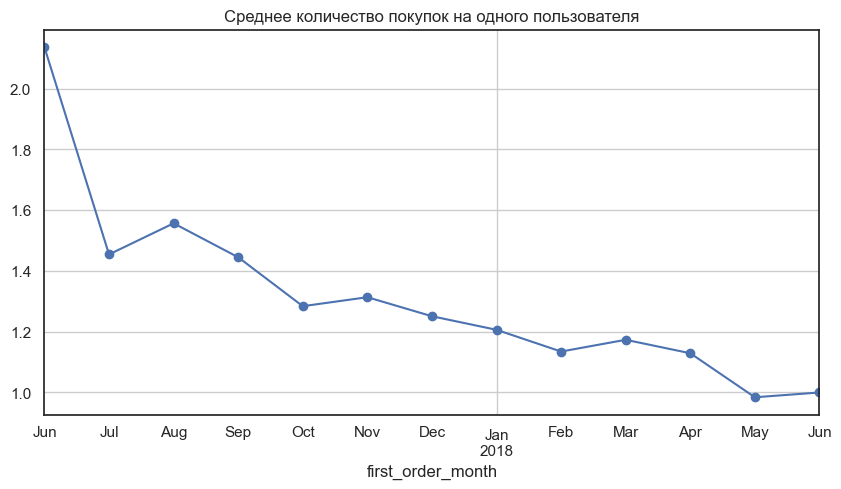

In [59]:
# Сгруппируем данные по столбцу `first_order_month` и оценим показатели каждой когорты:
cohorts = orders.groupby('first_order_month').agg(orders_count=('buy_ts','nunique'), 
                                                  users_nunique=('uid','nunique'), 
                                                  revenue=('revenue','sum'))

# Добавим в таблицу среднее количество покупок на одного пользователя когорты:
cohorts['orders_per_user'] = cohorts['orders_count'] / cohorts['users_nunique']
display(cohorts)

cohorts['orders_per_user'].plot(figsize=(10,5), grid=True, style='o-', title='Среднее количество покупок на одного пользователя по когортам')
plt.show()

* Среднее количество покупок на пользователя снижается, что логически и так понятно. Те, кто меньше находится на платформе, успели меньше покупок сделать
* Не смотря на это, показатель не очень высокий, те люди, у которых прошел год с момента первой покупки в среднем имеют только две покупки за это время

Посмотрим теперь на среднее количество покупок пользователя внутри одной когорты.

In [60]:
cohorts_month = orders.groupby(['first_order_month', 'order_month']).agg(orders_count=('buy_ts','nunique'),
                                                                         users_nunique=('uid','nunique'),
                                                                         revenue=('revenue','sum'))

# Добавим в таблицу среднее количество покупок на одного пользователя:
cohorts_month['orders_per_user'] = cohorts_month['orders_count'] / cohorts_month['users_nunique']
display(cohorts_month)

orders_count  users_nunique   revenue  \
first_order_month order_month                                          
2017-06-01        2017-06-01           2245           2023   9557.49   
                  2017-07-01            176             61    981.82   
                  2017-08-01            174             50    885.34   
                  2017-09-01            223             54   1931.30   
                  2017-10-01            292             88   2068.58   
...                                     ...            ...       ...   
2018-03-01        2018-05-01            176             58   1114.87   
2018-04-01        2018-04-01           2375           2276  10600.69   
                  2018-05-01            195             69   1209.92   
2018-05-01        2018-05-01           2941           2988  13925.76   
2018-06-01        2018-06-01              1              1      3.42   

                               orders_per_user  
first_order_month order_month                   
2017-06-01        2017-06-01          1.109738  
                  2017-07-01          2.885246  
                  2017-08-01          3.480000  
                  2017-09-01          4.129630  
                  2017-10-01          3.318182  
...                                        ...  
2018-03-01        2018-05-01          3.034483  
2018-04-01        2018-04-01          1.043497  
                  2018-05-01          2.826087  
2018-05-01        2018-05-01          0.984270  
2018-06-01        2018-06-01          1.000000  

[79 rows x 4 columns]

Визуализируем данные выше

In [61]:
print('Среднее количество покупок на пользователя')
cohorts_month.pivot_table(index='first_order_month',
                          columns='order_month',
                          values='orders_per_user',
                          aggfunc='mean'
                         ).fillna('')

Среднее количество покупок на пользователя


order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,1.109738,2.885246,3.48,4.12963,3.318182,3.238806,4.435484,3.702128,3.655172,3.377778,2.133333,1.622642,
2017-07-01,,1.079563,1.923077,2.105263,1.609375,1.469388,2.157895,1.666667,1.25641,1.380952,1.090909,2.038462,
2017-08-01,,,1.081022,1.844828,1.886792,1.818182,2.1,1.9375,1.633333,1.772727,2.421053,1.483871,
2017-09-01,,,,1.079427,1.684615,1.6,2.216216,1.288462,1.703125,1.636364,1.513514,1.418605,
2017-10-01,,,,,1.04447,1.519417,1.317073,1.326087,1.387097,1.430556,1.535714,1.865672,
2017-11-01,,,,,,1.049743,1.756757,1.5,1.981132,1.679012,1.229167,1.645161,
2017-12-01,,,,,,,1.059092,1.842466,1.961165,1.845361,1.72,1.666667,
2018-01-01,,,,,,,,1.05129,1.947368,1.915663,1.488372,1.733333,
2018-02-01,,,,,,,,,1.03232,1.872881,1.431034,1.794872,


И посмотрим на количество активных покупателей каждой когорты помесячно.

In [62]:
print('Количество покупателей внутри когорты')
cohorts_month.pivot_table(index='first_order_month',
                          columns='order_month',
                          values='users_nunique',
                          aggfunc='mean'
                         ).fillna('')

Количество покупателей внутри когорты


order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,2023.0,61.0,50.0,54.0,88.0,67.0,62.0,47.0,58.0,45.0,45.0,53.0,
2017-07-01,,1923.0,52.0,57.0,64.0,49.0,38.0,36.0,39.0,42.0,22.0,26.0,
2017-08-01,,,1370.0,58.0,53.0,44.0,40.0,32.0,30.0,44.0,19.0,31.0,
2017-09-01,,,,2581.0,130.0,100.0,74.0,52.0,64.0,66.0,37.0,43.0,
2017-10-01,,,,,4340.0,206.0,123.0,92.0,93.0,72.0,56.0,67.0,
2017-11-01,,,,,,4081.0,222.0,120.0,106.0,81.0,48.0,62.0,
2017-12-01,,,,,,,4383.0,146.0,103.0,97.0,50.0,63.0,
2018-01-01,,,,,,,,3373.0,114.0,83.0,43.0,45.0,
2018-02-01,,,,,,,,,3651.0,118.0,58.0,39.0,


* Среднее количество покупок на пользователя с первого месяца покупки во всех когортах стабильно месяц-два увеличивается
* Самое большое количество покупателей, которые совершают первую покупку, выявлено в декабре, что логически можно в принципе объяснить
* В когортах, которые совершили свои первые покупки до декабря, среднее количество покупок на пользователя в декабре увеличивается, что также объяснимо
* А вот в общем количество покупателей в период с ноября по январь во всех когортах уменьшается
* Количество активных покупателей в каждой когорте резко уменьшается после первого месяца покупки (в среднем в 30 раз)

Рассчитаем средний чек

In [63]:
# Добавим в нашу группировку средний чек покупателя:
cohorts_month['revenue_per_user'] = cohorts_month['revenue'] / cohorts_month['users_nunique']

display(cohorts_month)

#Построим сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки:
cohorts_month.pivot_table(index='first_order_month',
                          columns='order_month',
                          values='revenue_per_user',
                          aggfunc='mean'
                         ).fillna('')

orders_count  users_nunique   revenue  \
first_order_month order_month                                          
2017-06-01        2017-06-01           2245           2023   9557.49   
                  2017-07-01            176             61    981.82   
                  2017-08-01            174             50    885.34   
                  2017-09-01            223             54   1931.30   
                  2017-10-01            292             88   2068.58   
...                                     ...            ...       ...   
2018-03-01        2018-05-01            176             58   1114.87   
2018-04-01        2018-04-01           2375           2276  10600.69   
                  2018-05-01            195             69   1209.92   
2018-05-01        2018-05-01           2941           2988  13925.76   
2018-06-01        2018-06-01              1              1      3.42   

                               orders_per_user  revenue_per_user  
first_order_month order_month                                     
2017-06-01        2017-06-01          1.109738          4.724414  
                  2017-07-01          2.885246         16.095410  
                  2017-08-01          3.480000         17.706800  
                  2017-09-01          4.129630         35.764815  
                  2017-10-01          3.318182         23.506591  
...                                        ...               ...  
2018-03-01        2018-05-01          3.034483         19.221897  
2018-04-01        2018-04-01          1.043497          4.657597  
                  2018-05-01          2.826087         17.535072  
2018-05-01        2018-05-01          0.984270          4.660562  
2018-06-01        2018-06-01          1.000000          3.420000  

[79 rows x 5 columns]

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.09541,17.7068,35.764815,23.506591,22.207761,31.011935,25.033191,19.29569,27.233556,25.681333,9.804151,
2017-07-01,,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,
2017-08-01,,,5.276518,11.148793,11.851321,12.182955,16.92125,12.139062,9.620333,12.610455,21.07,8.307419,
2017-09-01,,,,5.644529,22.188385,13.4452,138.669189,19.881538,26.095,27.437121,16.961351,11.044651,
2017-10-01,,,,,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,
2017-11-01,,,,,,5.154683,7.339054,6.786583,12.51066,7.457284,4.580833,7.564839,
2017-12-01,,,,,,,4.738191,7.816575,39.366019,48.135052,27.4314,23.518413,
2018-01-01,,,,,,,,4.135636,8.721228,12.365542,11.199767,4.699556,
2018-02-01,,,,,,,,,4.156987,8.61,4.942414,6.941026,


* Средний чек первой покупки в каждой когорте меньше среднего чека следующего месяца.
* Очень сильно выделяется средний чек декабря в сентябрьской когорте - 138.7 и в целом средний чек в декабре во всех когортах увеличивается.
* Самые продолжительные увеличения среднего чека после первой покупки в когортах августа и декабря.
* Также средний чек практически во всех когортах увеличивается в марте.

***LTV*** или Lifetime Value — пожизненная ценность клиента - сколько денег клиент принёс компании за всё время взаимодействия с ней. Это может быть и чистая прибыль от клиента, и доход от всех его заказов.

Рассчитаем итоговую сумму денег, которую пользователь приносит со всех своих покупок.

In [70]:
display(report.head())

,first_order_month,n_buyers,order_month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531


In [67]:
# Месяц первой покупки каждого пользователя:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

# Посчитаем количество новых покупателей `n_buyers` за каждый месяц:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
#display(cohort_sizes.head())

cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
#display(cohorts.head())

report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(30, 'D')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']

#display(report.head())

output = report.pivot_table(index='first_order_month', 
                            columns='age', 
                            values='ltv', 
                            aggfunc='mean')

print('Средняя сумма денег, которую приносит пользователь с течением времени (накопительная)')
display(output.cumsum(axis=1).round(2).fillna(''))

Средняя сумма денег, которую приносит пользователь с течением времени (накопительная)


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5.0,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


,first_order_month,ltv
0,2017-06-01,11.879234
1,2017-07-01,8.386854
2,2017-08-01,8.471723
3,2017-09-01,13.435227
4,2017-10-01,6.360242
5,2017-11-01,6.395244
6,2017-12-01,7.639913
7,2018-01-01,4.940151
8,2018-02-01,4.587921
9,2018-03-01,5.455253


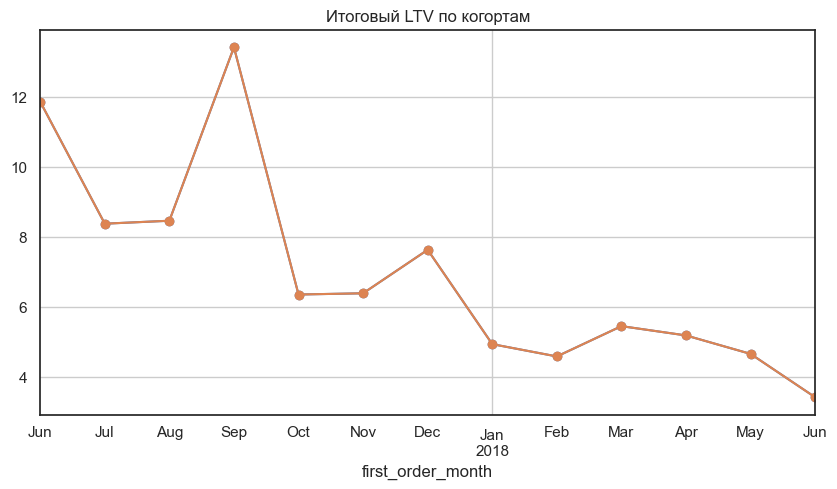

In [75]:
# Итоговый LTV по когортам:
report.groupby('first_order_month')['ltv'].sum().plot(figsize=(10,5), grid=True, style='o-', title='Итоговый LTV по когортам')
display(report.groupby('first_order_month')['ltv'].sum().reset_index())
plt.show()

Такой подсчёт не слишком информативен, т.к. не учитывает продолжительность жизни когорт. Подсчитаем и сравним средние показатели шести первых когорт вплоть до их седьмого месяца жизни (0-6).

,first_order_month,ltv
0,2017-06-01,9.310524
1,2017-07-01,7.780983
2,2017-08-01,7.586526
3,2017-09-01,13.008071
4,2017-10-01,6.244772
5,2017-11-01,6.395244


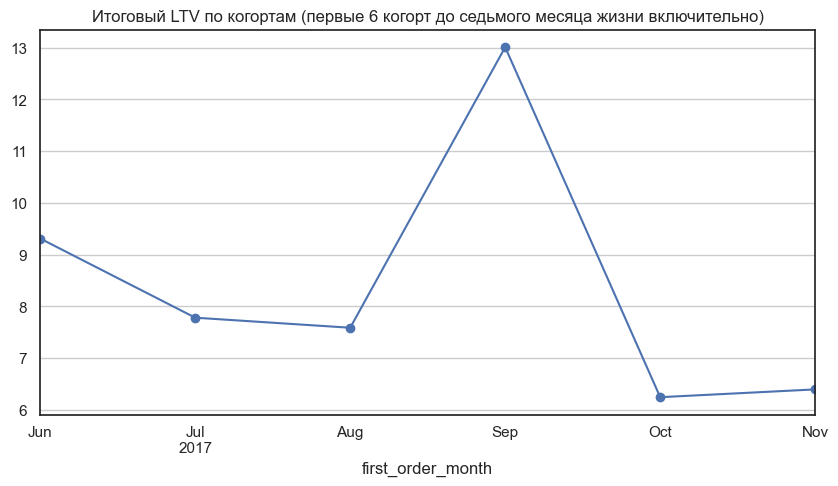

In [76]:
display(report.query('(first_order_month < "2017-12-01") & (age < 7)').groupby('first_order_month')['ltv'].sum().reset_index())

report.query('(first_order_month < "2017-12-01") & (age < 7)').groupby('first_order_month')['ltv'].sum().plot(figsize=(10,5), grid=True, style='o-', title='Итоговый LTV по когортам (первые 6 когорт до седьмого месяца жизни включительно)')
plt.show()

* Больше всего прибыли принесли пользователи, которые совершили первую покупку в сентябре, что понятно, мы видели уже на графике среднего чека по когортам большое значение в декабре как раз у данной когорты.
* За исключением сентября тенденция прибыли от пользователя по когортам снижается.

Рассчитаем ***CAC*** или Customer Acquisition Cost (стоимость привлечения клиента) каждой когорты.

In [78]:
# Добавим в таблицу `costs` поле с месяцем расхода:
marketing['cost_month'] = marketing['dt'].values.astype('datetime64[M]')

# Посчитаем расходы за месяц:
monthly_costs = marketing.groupby('cost_month')['costs'].sum()
monthly_costs.head()

cost_month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
Name: costs, dtype: float64

In [79]:
# Добавим данные о расходах в отчёт и посчитаем CAC:
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='cost_month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

,first_order_month,n_buyers,order_month,revenue,age,ltv,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531,18015.0,8.905091


Рассчитаем ***ROMI*** (возврат на инвестиции) по каждой когорте.

ROMI помогает понять, удалось ли вернуть затраты, которые компания вложила в рекламу. 

***Чем выше ROMI, тем лучше:***
* ROMI должен быть больше 100%. Это значит, что реклама приносит прибыль, каждый вложенный рубль возвращается и приносит доход.
* ROMI, равный 100% — это точка безубыточности: такой показатель говорит о том, что вложенные инвестиции возвращаются без дохода.
* Показатель ROMI меньше 100% говорит о том, что вложения в маркетинг не окупаются.

In [80]:
# Поделим LTV на CAC:
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

print('Накопительный ROMI:')
output.cumsum(axis=1).round(2).fillna('')

Накопительный ROMI:


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


* Июньская когорта окупилась на 6-й месяц жизни (к декабрю)
* Сентябрьская когорта - на 3-й месяц жизни (к декабрю)
* Остальные пока не успели окупиться.

#### Маркетинг

***Сколько денег потратили всего/на один источник/по времени***

***Сколько стоит привлечение одного покупателя из каждого источника?***

***На сколько окупились расходы?(ROI)***

Оценим финансовые результаты работы сервиса за рассматриваемый период.

,month,revunue,costs,total
0,2017-06-01,9557.49,18015.00,-8457.51
1,2017-07-01,12539.47,18240.59,-5701.12
2,2017-08-01,8758.78,14790.54,-6031.76
3,2017-09-01,18345.51,24368.91,-6023.40
4,2017-10-01,27987.70,36322.88,-8335.18
5,2017-11-01,27069.93,37907.88,-10837.95
6,2017-12-01,36388.60,38315.35,-1926.75
7,2018-01-01,19417.13,33518.52,-14101.39
8,2018-02-01,25560.54,32723.03,-7162.49
9,2018-03-01,28834.59,30415.27,-1580.68


Суммарная выручка: 252057.2
Суммарные затраты: 329131.62
Итого(сум.выручка-сум.затраты): -77074.42


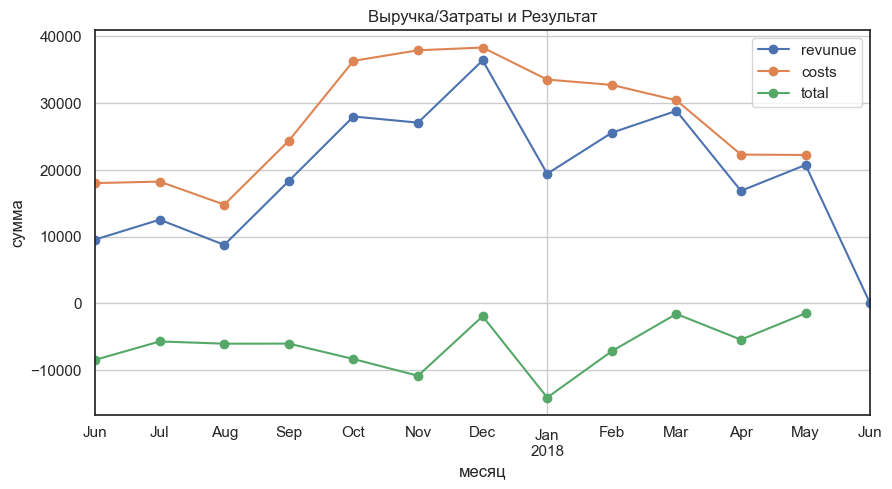

In [82]:
# Сгруппируем затраты и заказы по месяцу:
gross_profit_per_month = orders.groupby('order_month').agg(revunue=('revenue','sum')).reset_index()
costs_per_month = marketing.groupby('cost_month').agg(costs=('costs','sum')).reset_index()

# Объединим ежемесячные затраты с выручкой и посчитаем результат:
#totals_per_month = gross_profit_per_month.set_index('order_month').join(costs_per_month.set_index('cost_month'))
totals_per_month = gross_profit_per_month.merge(costs_per_month, how='outer',  left_on='order_month', right_on='cost_month')
totals_per_month['total'] = totals_per_month['revunue'] - totals_per_month['costs']
totals_per_month.drop(['cost_month'], axis='columns', inplace=True)
totals_per_month = totals_per_month.rename(columns={'order_month': 'month'})

display(totals_per_month)
print('Суммарная выручка:', round(totals_per_month['revunue'].sum(), 2))
print('Суммарные затраты:', round(totals_per_month['costs'].sum(), 2))
print('Итого(сум.выручка-сум.затраты):', round(totals_per_month['revunue'].sum() - totals_per_month['costs'].sum(), 2))

totals_per_month = totals_per_month.set_index('month')
totals_per_month.plot(figsize=(10,5), grid=True, style='o-', title='Выручка/Затраты и Результат')
plt.xlabel('месяц')
plt.ylabel('сумма')
plt.show()

* За рассматриваемый период сервис сработал с убытком в -77077.84
* Самые хорошие результаты с точки зрения разницы прибыли и убытков наблюдаются в декабре, марте и мае. Наименьший убыток в мае.

source_id
3     141321.63
4      61073.60
5      51757.10
2      42806.04
1      20833.27
10      5822.49
9       5517.49
Name: costs, dtype: float64

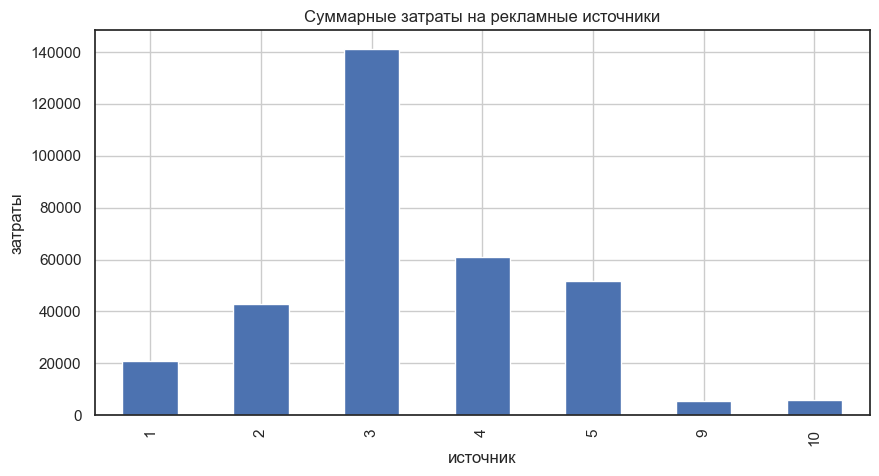

In [83]:
# Рассмотрим суммарные затраты на рекламные источники:
source_costs = marketing.groupby('source_id')['costs'].sum()
display(source_costs.sort_values(ascending=False))

source_costs.plot(figsize=(10,5), grid=True, kind='bar', title='Суммарные затраты на рекламные источники')
plt.xlabel('источник')
plt.ylabel('затраты')
plt.show()

* Больше всего денег было потрачено на 3-й рекламный источник, почти в 2 раза меньше - на 4-й, и в 3 раза меньше - на 5-й.
* 6-й, 7-й и 8-й рекламные источники в наших данных не встречались, т.е. данные источники в данный период деньги не использовались.

Подсчитаем стоимость привлечения покупателя по каждому источнику.

In [84]:
# Составим справочник с источниками, через которые пользователи впервые попали на площадку сервиса:
source_per_user = visits.groupby(['uid','source_id']).agg({'start_ts':'min'}).reset_index()
#ищем самое первое появление пользователя и его источник
source_per_user = source_per_user.sort_values(['uid','start_ts'], ascending=[True,True]).drop_duplicates('uid')
source_per_user.drop(['start_ts'], axis='columns', inplace=True)

display(source_per_user.head(5))

,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


In [85]:
# Добавим в таблицу с заказами информацию о рекламном источнике, через который пользователь впервые попал на сервис:
orders = orders.merge(source_per_user, on='uid', how='left')
display(orders.head())

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,3


,revenue,nusers,costs,costs_per_user,revenue_per_user
source_id,,,,,
1,31090.55,2899,20833.27,7.186364,10.724577
2,46923.61,3506,42806.04,12.209367,13.383802
3,54511.24,10473,141321.63,13.493901,5.204931
4,56696.83,10296,61073.60,5.931779,5.506685
5,52624.02,6931,51757.10,7.467479,7.592558
7,1.22,1,NaN,NaN,1.220000
9,5759.40,1088,5517.49,5.071222,5.293566
10,4450.33,1329,5822.49,4.381106,3.348631


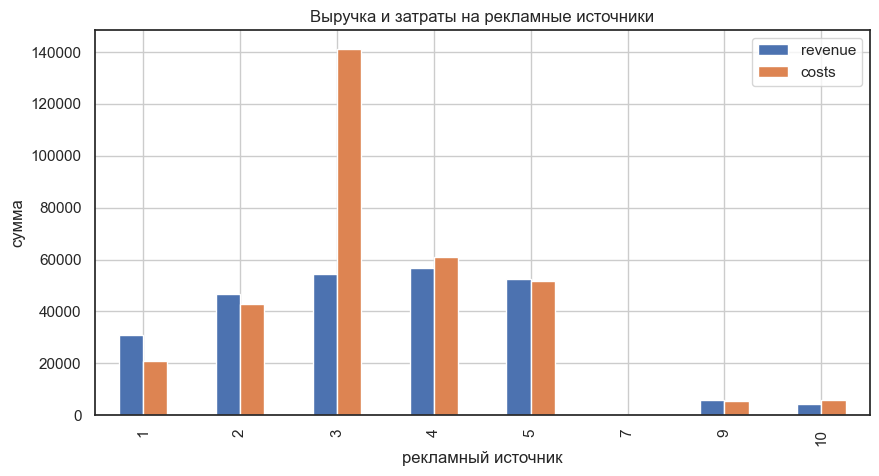

In [86]:
# Подсчитаем количество покупателей из каждого источника, а также суммарную выручку по источнику:
source_result = orders.groupby('source_id').agg({'revenue':'sum','uid':'nunique'}).reset_index()
source_result.columns = ('source_id','revenue','nusers')

# Добавим затраты:
source_result = source_result.merge(source_costs, on='source_id', how='outer')

# Рассчитаем среднюю стоимость привлечения пользователя по источнику:
source_result['costs_per_user'] = source_result['costs'] / source_result['nusers']

# Рассчитаем среднюю выручку с каждого пользователя по источнику:
source_result['revenue_per_user'] = source_result['revenue'] / source_result['nusers']

source_result = source_result.set_index('source_id')
display(source_result)

source_result[['revenue','costs']].plot(figsize=(10,5), grid=True, kind='bar', title='Выручка и затраты на рекламные источники')
plt.xlabel('рекламный источник')
plt.ylabel('сумма')
plt.show()

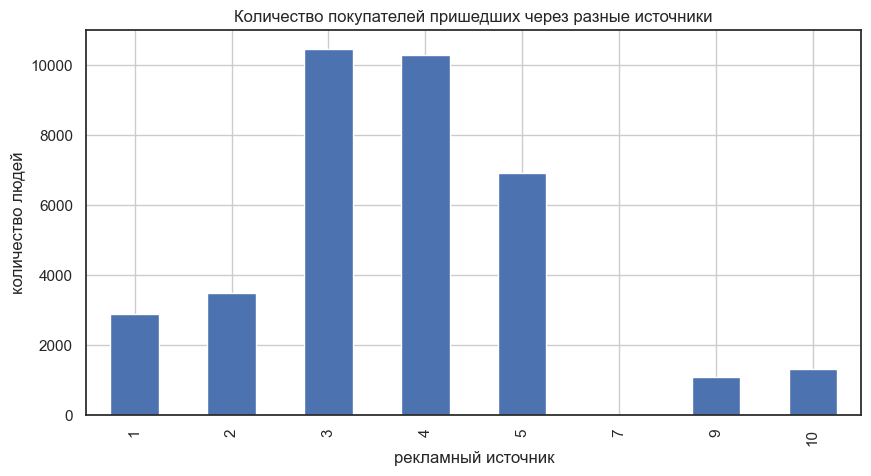

In [89]:
source_result['nusers'].plot(figsize=(10,5), grid=True, kind='bar', title='Количество покупателей пришедших через разные источники')
plt.xlabel('рекламный источник')
plt.ylabel('количество людей')
plt.show()

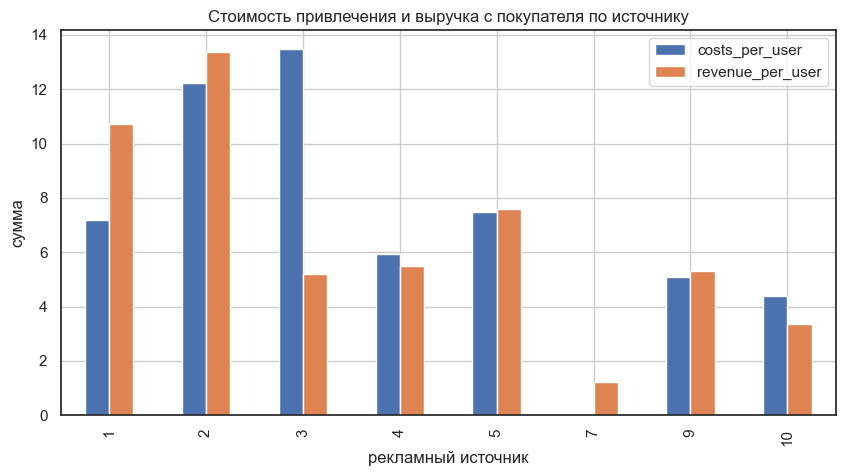

In [90]:
# Посмотрим график средней стоимости привлечения и средней выручки с покупателя по источнику:
source_result[['costs_per_user', 'revenue_per_user']].plot(figsize=(10,5), grid=True, kind='bar', title='Стоимость привлечения и выручка с покупателя по источнику')
plt.xlabel('рекламный источник')
plt.ylabel('сумма')
plt.show()

* Связь между затратами и выручкой по источнику не наблюдается.
* Больше всего покупателей пришло из 3-го, 4-го и 5-го рекламного источника.
* Наибольшей отдачей отличаются 1-й и 2-й рекламные источники. 5-й и 9-й тоже в плюсе, но небольшом.
* Затраты на 3-й источник явно не оправдали себя.

Посчитаем ***ROI*** (окупаемость расходов) по рекламным источникам.

***ROI (Return on Investment)*** — это коэффициент окупаемости или показатель возврата всех инвестиций. В отличие от показателя ROMI, который учитывает только маркетинговые затраты, ROI помогает определить, насколько выгоден весь проект с учетом всех вложений в него. Чтобы определить ROI, необходимо учесть все затраты на проект и доходы с него.

In [91]:
source_result['roi'] = source_result['revenue'] / source_result['costs'] # точка окупаемости: 100%
print(round(source_result['roi'] * 100),2)

source_id
1     149.0
2     110.0
3      39.0
4      93.0
5     102.0
7       NaN
9     104.0
10     76.0
Name: roi, dtype: float64 2


* Окупились только 1-й, 2-й, 9-й и 5-й источники.
* Самым невыгодным оказался 3-й источник - вложения в него окупились только на 39%.

Рассмотрим статистику использования ***платформ.***

In [93]:
output = visits.groupby(['device']).agg({'uid':'count', 'session_duration_sec':'mean'})
output['percent_device'] = output['uid']/output['uid'].sum()
display(output)

,uid,session_duration_sec,percent_device
device,,,
desktop,262567,703.946977,0.73057
touch,96833,479.619407,0.26943


* 73% пользователей заходят на Афишу через компьютер.
* Средняя продолжительность посещений через компьютер почти в 1.5 раза выше, чем через телефон.

In [94]:
print('Средняя продолжительность сессии (зависимость от платформы и источника):')
visits.pivot_table(index='device', columns='source_id', values='session_duration_sec', aggfunc='mean')

Средняя продолжительность сессии (зависимость от платформы и источника):


source_id,1,2,3,4,5,6,7,9,10
device,,,,,,,,,
desktop,1132.429404,924.798519,616.623060,615.062212,573.544529,1608.0,642.857143,612.250618,736.028777
touch,746.105596,606.039866,429.546866,450.478743,387.555536,180.0,480.000000,445.312223,458.493604


* Пользователи, зашедшие с компьютера, в среднем пользуются сервисом дольше тех, кто зашёл с телефона - по всем рекламным источникам.
* Максимальная продолжительность наблюдается среди пользователей, зашедших на сервис с компьютера через 6-й рекламный источник. Там же наблюдается минимальная продолжительность среди тех, кто вошёл с телефона.

### Результаты по всем блокам:

#### Посещаемость:

* В среднем на пользователя приходится в 1.28 сесиий в месяц, т.е. из четырёх человек только один заходит на Афишу два раза в месяц, остальные - единожды.
* Среднее количество уникальных пользователей в месяц - 23228, количество сессий - 29950.

***По неделям и дням показатели следующие:***
* Среднее количество пользователей в неделю - 5715, среднее количество сессий - 6781.
* Среднее количесво пользователей в день - 900, сессий - 990.

* Продолжительность сессии: Чаще всего сессия пользователя длится 60 секунд вне зависимости от платформы, но если сессия продолжительная, то средняя продолжительность сессии на компьютере в 2 раза больше, чем на другой платформе.
* Всплеск количества сессий и пользователей в ноябре

***Показатели удержания пользователя:***

***Sticky factor:***
* DAU/WAU (week sticky factor): 15.88%
* DAU/MAU (month sticky factor): 3.91%
Получили не сильно хорошие результаты, вероятность того, что новый привлеченный пользователь останется в продукте довольно мала.
* Retention Rate (коэффициент удержания) также крайне низкий и с течением времени падает (как внутри когорты, так и от когорты к когорте).

#### Продажи:

* Доля пользователей, совершивших хотя бы одну покупку: 16.01%
* Большинство пользователей совершают покупку в день своей первой сессии.
* Количество активных покупателей в каждой когорте резко уменьшается после первого месяца покупки (в среднем в 30 раз).
* Среднее количество покупок на пользователя с первого месяца покупки во всех когортах стабильно месяц-два увеличивается.


* Средний чек первой покупки в каждой когорте меньше следующего.
* Очень сильно выделяется средний чек декабря в сентябрьской когорте - 138.7 и в целом средний чек в декабре во всех когортах увеличивается.
* Самые продолжительные увеличения среднего чека после первой покупки в когортах августа и декабря.
* Также средний чек практически во всех когортах увеличивается в марте.

* Больше всего прибыли принесли пользователи, которые совершили первую покупку в сентябре (за счёт крупной покупки в декабре).
* За исключением сентября тенденция прибыли от пользователя по когортам снижается.
* Июньская когорта окупилась на 6-й месяц жизни, сентябрьская когорта - на 3-й месяц жизни, обе в декабре, остальные не окупились пока.

#### Маркетинг:

* За рассматриваемый период сервис сработал с убытком в -77077.84
* Самые хорошие результаты с точки зрения разницы прибыли и убытков наблюдаются в декабре, марте и мае (там убыток был минимальным).


* Больше всего денег было потрачено на 3-й рекламный источник, почти в 2 раза меньше - на 4-й, и в 3 раза меньше - на 5-й.
* На 6-й, 7-й и 8-й рекламные источники не использовали в рассматриваемый период.
* Больше всего покупателей пришло из 3-го, 4-го и 5-го рекламного источника.
* Наибольшей отдачей отличаются 1-й и 2-й рекламные источники. 5-й и 9-й тоже в плюсе, но небольшом.
* Затраты на 3-й источник явно не оправдали себя.

***ROI:***
* Окупились только 1-й, 2-й, 9-й и 5-й источники.
* Самым невыгодным оказался 3-й источник - вложения в него окупились только на 39%.
Платформы

* 73% пользователей заходят на Афишу через компьютер.
* Средняя продолжительность посещений через компьютер почти в 1.5 раза больше, чем через телефон.
* Пользователи, зашедшие с компьютера, в среднем пользуются сервисом дольше тех, кто зашёл с телефона - по всем рекламным источникам.
* Максимальная продолжительность наблюдается среди пользователей, зашедших на сервис с компьютера через 6-й рекламный источник. Там же наблюдается минимальная продолжительность среди тех, кто вошёл с телефона.


#### Итоги
За рассматриваемый период сервис сработал с убытком, коэффициент удержания пользователей крайне низкий - есть над чем поработать.

Имеет смысл обратить внимание на пользователей, совершивших первую покупку в июне 2017 года - их ежемесячный средний чек выше средних чеков почти всех остальных когорт - возможно, имела место какая-то маркетинговая кампания, показавшая хорошие результаты. То же касается и декабрьской когорты, в которой, начиная с февраля, наблюдаются высокие значения среднего чека.

Учитывая, что большинство покупателей попали на сервис через 3-й, 4-й и 5-й рекламные источники, а окупился из них только 5-й, стоит вложится именно в него. Также стоит обратить внимание на 1-й и 2-й рекламные источники, окупившиеся в рассматриваемый период.

Т.к. более 70% пользователей заходят на Афишу через компьютер и средняя продолжительность сессии выше именно на этой платформе, стоит ориентироваться на неё.